In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time as time

import torch
from astropy.io import fits
from astropy.utils.data import download_file

from mpol import (
    coordinates,
    crossval,
    datasets,
    gridding,
    images,
    fourier,
    losses,
    precomposed,
)

from training_func import train

In [9]:
from torch.utils.tensorboard import SummaryWriter

2024-03-14 16:00:32.997519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
# input parameters
###########################################################################################################################################
fname = '../data/visibilities/mock_visibilities_model_star_delta.npz' # path to the .npz file containing the observed visibilities
cell_size = 0.03 # arcseconds
npix = 128 # number of pixels per image axis
learning_rate = 0.3 # learning rate for the optimizer
# n_iter = 25 # number of iterations for the optimizer

start_from_dirty_image = False # If True, the initial BaseCube image is set to the dirty image, else to the default flat image.
###########################################################################################################################################

In [53]:
# this is a multi-channel dataset... for demonstration purposes we'll use
# only the central, single channel
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)

# define the image dimensions, making sure they are big enough to fit all
# of the expected emission
coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)
averager = gridding.DataAverager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# export to PyTorch dataset
dset = averager.to_pytorch_dataset()

dset

GriddedDataset()

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

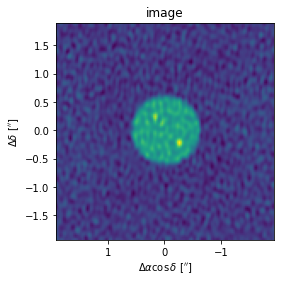

In [54]:
imager = gridding.DirtyImager(
    coords=coords, uu=uu, vv=vv, weight=weight, data_re=data_re, data_im=data_im
)

# Show the dirty image
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(img), **kw)
ax.set_title("image")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

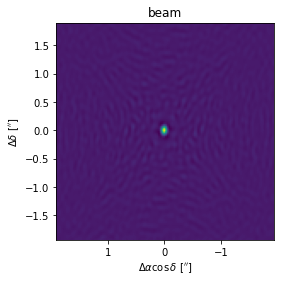

In [55]:
# Show the dirty beam
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)
kw = {"origin": "lower", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=1)
ax.imshow(np.squeeze(beam), **kw)
ax.set_title("beam")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

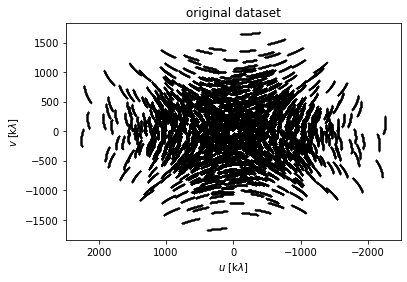

In [56]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(
    -uu, -vv, s=1.5, rasterized=True, linewidths=0.0, c="k"
)  # and Hermitian conjugates
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_title("original dataset")
ax.invert_xaxis()

In [57]:
# create a radial and azimuthal partition
dartboard = datasets.Dartboard(coords=coords)

# create cross validator using this "dartboard"
k = 5
cv = crossval.DartboardSplitGridded(dset, k, dartboard=dartboard, seed=42)

# ``cv`` is a Python iterator, it will return a ``(train, test)`` pair of ``GriddedDataset``s for each iteration.
# Because we'll want to revisit the individual datasets
# several times in this tutorial, we're storeing them into a list
k_fold_datasets = [(train, test) for (train, test) in cv]

# k_fold_datasets[0][0].vis_gridded.shape

k_fold_datasets[0][0].ground_mask[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

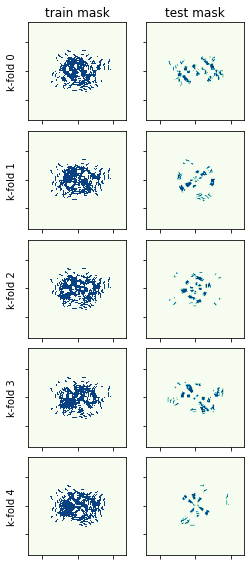

In [58]:
fig, ax = plt.subplots(nrows=k, ncols=2, figsize=(4, 10))

for i, (train_subset, test_subset) in enumerate(k_fold_datasets):

    # train_subset and test_subset are `GriddedDataset`s

    train_mask = train_subset.ground_mask[0]
    test_mask = test_subset.ground_mask[0]

    ax[i, 0].imshow(
        train_mask.detach().numpy(),
        interpolation="none",
        origin="lower",
        extent=coords.vis_ext,
        cmap="GnBu",
    )

    ax[i, 1].imshow(
        test_mask.detach().numpy(), origin="lower", extent=coords.vis_ext, cmap="GnBu"
    )

    ax[i, 0].set_ylabel("k-fold {:}".format(i))

ax[0, 0].set_title("train mask")
ax[0, 1].set_title("test mask")

for a in ax.flatten():
    a.xaxis.set_ticklabels([])
    a.yaxis.set_ticklabels([])

fig.subplots_adjust(left=0.15, hspace=0.0, wspace=0.2)

In [59]:
# def train(model, dset, config, optimizer, writer=None):
#     model.train()  # set to training mode

#     for i in range(config["epochs"]):
#         model.zero_grad()

#         # get the predicted model
#         vis = model()

#         # get the sky cube too
#         sky_cube = model.icube.sky_cube

#         # calculate a loss
#         loss = (
#             losses.nll_gridded(vis, dset)
#             + config["lambda_sparsity"] * losses.sparsity(sky_cube)
#             + config["lambda_TV"] * losses.TV_image(sky_cube)
#         )

#         if writer is not None:
#             writer.add_scalar("loss", loss.item(), i)

#         # calculate gradients of parameters
#         loss.backward()

#         # update the model parameters
#         optimizer.step()

In [60]:
def test(model, dset):
    model.train(False)
    # evaluate test score
    vis = model()
    loss = losses.nll_gridded(vis, dset)
    return loss.item()

In [61]:
def cross_validate(config):
    """
    config is a dictionary that should contain ``lr``, ``lambda_sparsity``, ``lambda_TV``, ``epochs``
    """
    test_scores = []

    for k_fold, (train_dset, test_dset) in enumerate(k_fold_datasets):

        # create a new model and optimizer for this k_fold
        rml = precomposed.SimpleNet(coords=coords, nchan=train_dset.nchan)
        optimizer = torch.optim.Adam(rml.parameters(), lr=config["lr"])

        # train for a while
        # train(rml, train_dset, config, optimizer)
        loss_tracker = train(rml=rml, dset=train_dset, hyperparams_config=config, optimizer=optimizer)
        # evaluate the test metric
        test_scores.append(test(rml, test_dset))

    # aggregate all test scores and sum to evaluate cross val metric
    test_score = np.sum(np.array(test_scores))

    return test_score

In [62]:
def train_and_image(pars):
    rml = precomposed.SimpleNet(coords=coords, nchan=dset.nchan)
    optimizer = torch.optim.Adam(rml.parameters(), lr=pars["lr"])
    writer = SummaryWriter()
    # train(rml, dset, pars, optimizer, writer=writer)
    loss_tracker = train(rml=rml, dset=dset, hyperparams_config=pars, optimizer=optimizer, writer=writer)
    writer.close()

    img_ext = rml.coords.img_ext
    fig, ax = plt.subplots()
    ax.imshow(
        np.squeeze(rml.icube.sky_cube.detach().numpy()), origin="lower", extent=img_ext
    )
    return fig, ax

In [63]:
# form of loss function with regularizers

'''
loss = (
    losses.nll_gridded(vis, dset)
    + hyperparams_config["lambda_sparsity"] * losses.sparsity(sky_cube)
    + hyperparams_config["lambda_TV"] * losses.TV_image(sky_cube)
    + hyperparams_config["entropy"] * losses.entropy(sky_cube, hyperparams_config["prior_intensity"])
    + hyperparams_config["TSV"] * losses.TSV(sky_cube)
)
'''

'\nloss = (\n    losses.nll_gridded(vis, dset)\n    + hyperparams_config["lambda_sparsity"] * losses.sparsity(sky_cube)\n    + hyperparams_config["lambda_TV"] * losses.TV_image(sky_cube)\n    + hyperparams_config["entropy"] * losses.entropy(sky_cube, hyperparams_config["prior_intensity"])\n    + hyperparams_config["TSV"] * losses.TSV(sky_cube)\n)\n'

Cross validation score: 8.462360227917022


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

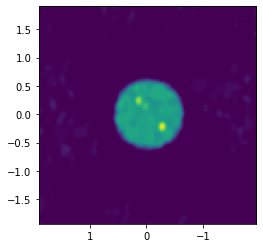

In [64]:
pars = {'lr': 0.5,
        'lambda_sparsity': 1.0e-4,
        'lambda_TV': 1.0e-4,
        'entropy': 1.0e-4,
        'prior_intensity': 1.0e-7,
        'TSV': 1.0e-4,
        "epochs": 600}

print("Cross validation score:", cross_validate(pars))
train_and_image(pars)

In [29]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
# Define missing variables
lambda_sparsity_space = np.logspace(-6, -3, 3)
#lambda_TV_space = np.logspace(-6, -3, 3)
lambda_TV_space = np.array([1.0e-6])
entropy_space = np.logspace(-6, -3, 3)
TSV_space = np.logspace(-6, -3, 3)

# Fix code block
cv_dataframe = pd.DataFrame(columns=['lambda_sparsity', 'lambda_TV', 'entropy', 'TSV', 'cross_val_score'])
parameter_total = len(lambda_sparsity_space)*len(lambda_TV_space)*len(entropy_space)*len(TSV_space)
start_time = time.time()
for sparsity_index, lambda_sparsity in enumerate(lambda_sparsity_space):
    for TV_index, lambda_TV in enumerate(lambda_TV_space):
        for entropy_index, entropy in enumerate(entropy_space):
            for TSV_index, TSV in enumerate(TSV_space):
                parameter_count=sparsity_index*len(lambda_TV_space)*len(entropy_space)*len(TSV_space)+TV_index*len(entropy_space)*len(TSV_space)+entropy_index*len(TSV_space)+TSV_index
                print(f"[{parameter_count}/{parameter_total}]")
                run_time_start = time.time()
                pars = {'lr': 0.5,
                        'lambda_sparsity': lambda_sparsity,
                        'lambda_TV': lambda_TV,
                        'entropy': entropy,
                        'prior_intensity': 1.0e-7,
                        'TSV': TSV,
                        "epochs": 600}
                cv_score = cross_validate(pars)
                print("Cross validation score:", cv_score)
                cv_dataframe = pd.concat([cv_dataframe, pd.DataFrame({'lambda_sparsity': lambda_sparsity, 'lambda_TV': lambda_TV, 'entropy': entropy, 'TSV': TSV, 'cross_val_score': cv_score}, index=[0])], ignore_index=True)
                # train_and_image(pars)
                run_time_end = time.time()
                print(f"runtime: {(run_time_end-run_time_start):.1f}\n")

end_time = time.time()
print("Time taken for cross validation:{:.2f} minutes".format((end_time-start_time)/60))

Cross validation score: 93.42314527355333
runtime: 17.3

Cross validation score: 44.13289932187787
runtime: 17.0

Cross validation score: 38.8770167503799
runtime: 19.1

Cross validation score: 14.816274743667378
runtime: 16.7

Cross validation score: 11.333826828439843
runtime: 16.5

Cross validation score: 12.86697728137755
runtime: 16.8

Cross validation score: 16.838656310347027
runtime: 16.0

Cross validation score: 16.623826791581397
runtime: 18.5

Cross validation score: 17.463018275819067
runtime: 17.0

Cross validation score: 40.74606724823506
runtime: 16.4

Cross validation score: 32.66184200090814
runtime: 15.7

Cross validation score: 35.98866587731708
runtime: 16.3

Cross validation score: 11.308439331955626
runtime: 15.4

Cross validation score: 10.389200142793646
runtime: 15.7

Cross validation score: 12.643506828924028
runtime: 15.2

Cross validation score: 16.656079420659502
runtime: 15.8

Cross validation score: 16.50916231916598
runtime: 15.9

Cross validation score:

In [32]:
cv_dataframe.to_csv('cv_dataframe.csv', index=True)

In [33]:
cv_dataframe

,lambda_sparsity,lambda_TV,entropy,TSV,cross_val_score
0,0.000001,0.000001,0.000001,0.000001,93.423145
1,0.000001,0.000001,0.000001,0.000032,44.132899
2,0.000001,0.000001,0.000001,0.001,38.877017
3,0.000001,0.000001,0.000032,0.000001,14.816275
4,0.000001,0.000001,0.000032,0.000032,11.333827
...,...,...,...,...,...
76,0.001,0.001,0.000032,0.000032,11.125808
77,0.001,0.001,0.000032,0.001,12.353118
78,0.001,0.001,0.001,0.000001,27.381477
79,0.001,0.001,0.001,0.000032,27.446958


In [34]:
cv_dataframe.sort_values(by='cross_val_score', ascending=True)

,lambda_sparsity,lambda_TV,entropy,TSV,cross_val_score
48,0.000032,0.001,0.000032,0.000001,7.922292
49,0.000032,0.001,0.000032,0.000032,7.98042
21,0.000001,0.001,0.000032,0.000001,7.992882
45,0.000032,0.001,0.000001,0.000001,8.02986
22,0.000001,0.001,0.000032,0.000032,8.052081
...,...,...,...,...,...
11,0.000001,0.000032,0.000001,0.001,35.988666
2,0.000001,0.000001,0.000001,0.001,38.877017
9,0.000001,0.000032,0.000001,0.000001,40.746067
1,0.000001,0.000001,0.000001,0.000032,44.132899


In [ ]:
cv_dataframe.sort_values(by='cross_val_score', ascending=True)[]

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

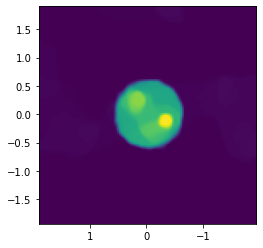

In [36]:
pars = {'lr': 0.5,
        'lambda_sparsity': cv_dataframe['lambda_sparsity'][48],
        'lambda_TV': cv_dataframe['lambda_TV'][48],
        'entropy': cv_dataframe['entropy'][48],
        'prior_intensity': 1.0e-7,
        'TSV': cv_dataframe['TSV'][48],
        "epochs": 600}

train_and_image(pars)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

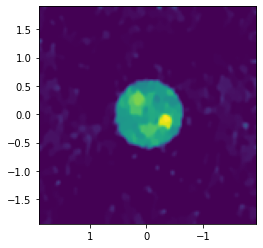

In [40]:
pars = {'lr': 0.5,
        'lambda_sparsity': cv_dataframe['lambda_sparsity'][48],
        'lambda_TV': 1e-4,
        'entropy': cv_dataframe['entropy'][48],
        'prior_intensity': 1.0e-7,
        'TSV': cv_dataframe['TSV'][48],
        "epochs": 600}

train_and_image(pars)